In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import re
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings('ignore')

In [1]:
# You can download the dataset here: 
# https://www.kaggle.com/brsdincer/star-type-classification

## Loading the Data

In [4]:
def load_data():

    column_names = ['Temperature', 
                   'RelativeLuminosity',
                   'RelativeRadius',
                   'ApparentMagnitude',
                   'Color',
                   'SpectralClass',
                   'Type']
    return pd.read_csv('./archive/Stars.csv', names=column_names, header=0)

df = load_data()
df.head()

,Temperature,RelativeLuminosity,RelativeRadius,ApparentMagnitude,Color,SpectralClass,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


## Checking if the Target is Imbalanced?

In [5]:
df.SpectralClass.value_counts()

M    112
B     46
O     40
A     19
F     17
K      6
Name: SpectralClass, dtype: int64

## Splitting the data with Stratified Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Type'), df['Type'],
                                                    test_size=0.30, random_state=1,
                                                    stratify= df['Type'])

## Some EDA - Tine Tiny, I promise

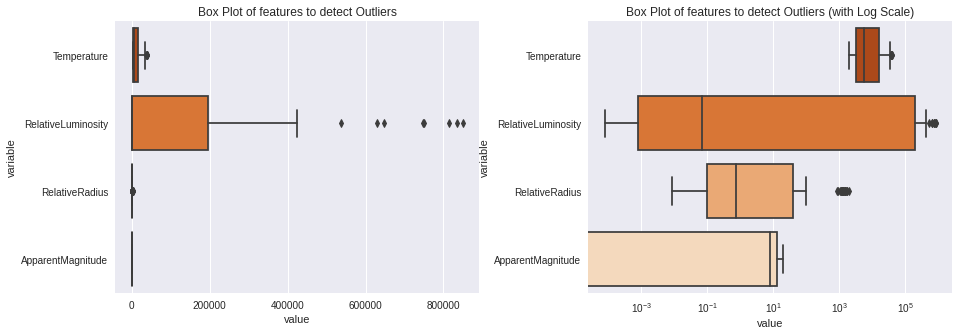

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('Box Plot of features to detect Outliers')
ax2.set_title('Box Plot of features to detect Outliers (with Log Scale)')
ax2.set_xscale('log')
plt.subplots_adjust(wspace=0.3)
ax1 = sns.boxplot(y="variable", x="value", data=pd.melt(numerical_xtrain),
            palette='Oranges_r', ax=ax1)
ax2 = sns.boxplot(y="variable", x="value", data=pd.melt(numerical_xtrain),
            palette='Oranges_r', ax=ax2)

In [9]:
def remove_outliers(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.2) # Ideally it is (.25 - .75 but I want the model to see outliers)
        Q3 = df[col].quantile(0.8)
        IQR = Q3 - Q1
        # print(col, IQR)
        # Adjusting outliers with their percentile values

        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR

        df[col] = np.where(df[col] < low, low, df[col])
        df[col] = np.where(df[col] > high, high, df[col])

    return df

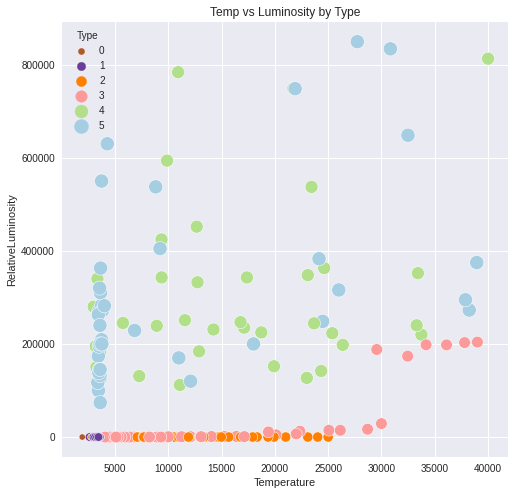

In [10]:
fig, ax_sns = plt.subplots(figsize=(8,8))
ax_sns.set_title('Temp vs Luminosity by Type')
ax_sns = sns.scatterplot(data=df, x='Temperature',
                         y='RelativeLuminosity', hue='Type',
                         size='Type', sizes=(40, 200),
                         palette='Paired_r', ax=ax_sns)

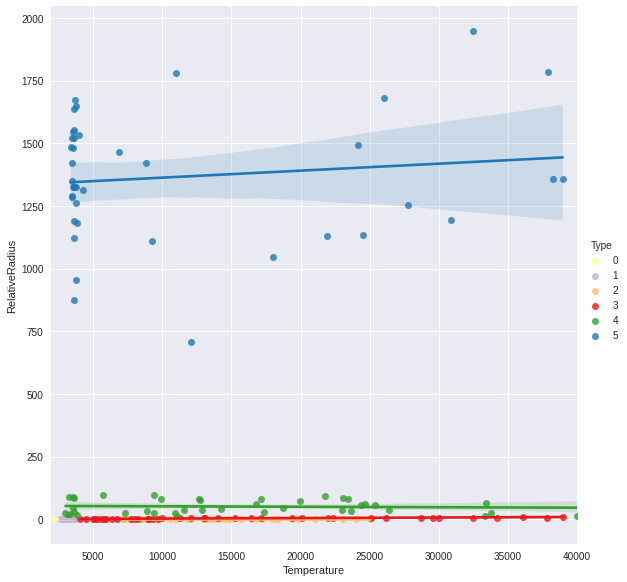

In [11]:
g = sns.lmplot(x='Temperature', y='RelativeRadius',
           data=df, hue='Type',
           palette='Paired_r', size=(8))
g.set_titles('Fitting Linear Model to estimate the Type')

## Building Pipelines
1. Numerical Transformer
2. Categorical Transformer
3. Combining them with ColumnTransformer
4. Plugging into Training Pipeline

In [12]:
class NumericalFeatureCleaner(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__(self):
        self._scalar = RobustScaler()
        return None

        
    # Return self nothing else to do here
    def fit(self, X, y =None):
        X = self._scalar.fit(X)
        return self

    
    def remove_outliers(self, X):
        for col in X.columns:
            Q1 = df[col].quantile(0.2)
            Q3 = df[col].quantile(0.8)
            IQR = Q3 - Q1
            # Adjusting outliers with their percentile values

            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR

            X[col] = np.where(X[col] < low, low, X[col])
            X[col] = np.where(X[col] > high, high, X[col])

        return X


        # Method calls several cleaner functions
    def transform(self, X, y = None):
       
        # Removing Outliers
        X = self.remove_outliers(X)

        
        # Scaling Features
        X = pd.DataFrame(self._scalar.transform(X), columns=X.columns, index=X.index)
        
        return X

In [74]:
class CategoricalFeatureCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    
    def fit(self, X, y=None):
        return self
    
    
    def get_features(self):
        return self.column_names
    
    
    def catToDummy(self, X):
        X = pd.get_dummies(X)
        return X
    
    
    def __formatColor(self, X):
        X = re.sub("[^A-Za-z]", "", x.lower())
        return X
    
    
    def transform(self, X, y=None):
        
        X = self.catToDummy(X)
        
        return X
        

In [14]:
numerical_columns = ['Temperature', 'RelativeLuminosity', 'RelativeRadius', 'ApparentMagnitude']
categorical_columns = ['SpectralClass']

In [54]:
transformer = ColumnTransformer(transformers=[
    ("numerical_transformer", NumericalFeatureCleaner(), numerical_columns),
    ("categorical_transformer", CategoricalFeatureCleaner(), categorical_columns)
    ], remainder='drop')
transformer.fit(X_train)

ColumnTransformer(transformers=[('numerical_transformer',
                                 NumericalFeatureCleaner(),
                                 ['Temperature', 'RelativeLuminosity',
                                  'RelativeRadius', 'ApparentMagnitude']),
                                ('categorical_transformer',
                                 CategoricalFeatureCleaner(),
                                 ['SpectralClass'])])

In [69]:

model = Pipeline(steps=[("pre-processor", transformer),
                       ("model", KNeighborsClassifier(n_neighbors=10, leaf_size=10))])

model.fit(X_train, y_train)

Pipeline(steps=[('pre-processor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  NumericalFeatureCleaner(),
                                                  ['Temperature',
                                                   'RelativeLuminosity',
                                                   'RelativeRadius',
                                                   'ApparentMagnitude']),
                                                 ('categorical_transformer',
                                                  CategoricalFeatureCleaner(),
                                                  ['SpectralClass'])])),
                ('model', KNeighborsClassifier(leaf_size=10, n_neighbors=10))])

In [70]:
result = cross_val_score(model ,X_train, y_train, cv = KFold(n_splits=3), error_score=-1)
 
print("Avg accuracy: {}".format(max(result)))

Avg accuracy: 0.9107142857142857


### I know it has over-fitted but hey, that was not the goal of this notebook
### Stay tuned as I create an automated pipeline for hyper-parameter tuning
### We will plug that with our existing solutions

In [71]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.90      1.00      0.95        28
           2       0.88      1.00      0.93        28
           3       0.96      0.79      0.86        28
           4       1.00      0.93      0.96        28
           5       1.00      1.00      1.00        28

    accuracy                           0.95       168
   macro avg       0.96      0.95      0.95       168
weighted avg       0.96      0.95      0.95       168



In [73]:
model.predict_proba(X_train)

array([[0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.2, 0.8, 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       ...,
       [0. , 0. , 0. , 0. , 0. , 1. ],
       [1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. ]])

In [2]:
# Thanks